In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as sp
from PIL import Image
from skimage.transform import (radon, iradon)
from scipy.spatial.transform import Rotation as R
from os.path import isdir
import os

import imageio.v2 as imageio

import time
import utils
import astra

import algotom.io.loadersaver as losa
import algotom.io.converter as cvr
import algotom.prep.correction as corr
import algotom.prep.calculation as calc
import algotom.prep.removal as remo
import algotom.prep.filtering as filt
import algotom.rec.reconstruction as rec

In [7]:
def extract_square(image, corner, side_length):
    return image[corner[0]:corner[0]+side_length, corner[1]:corner[1]+side_length]

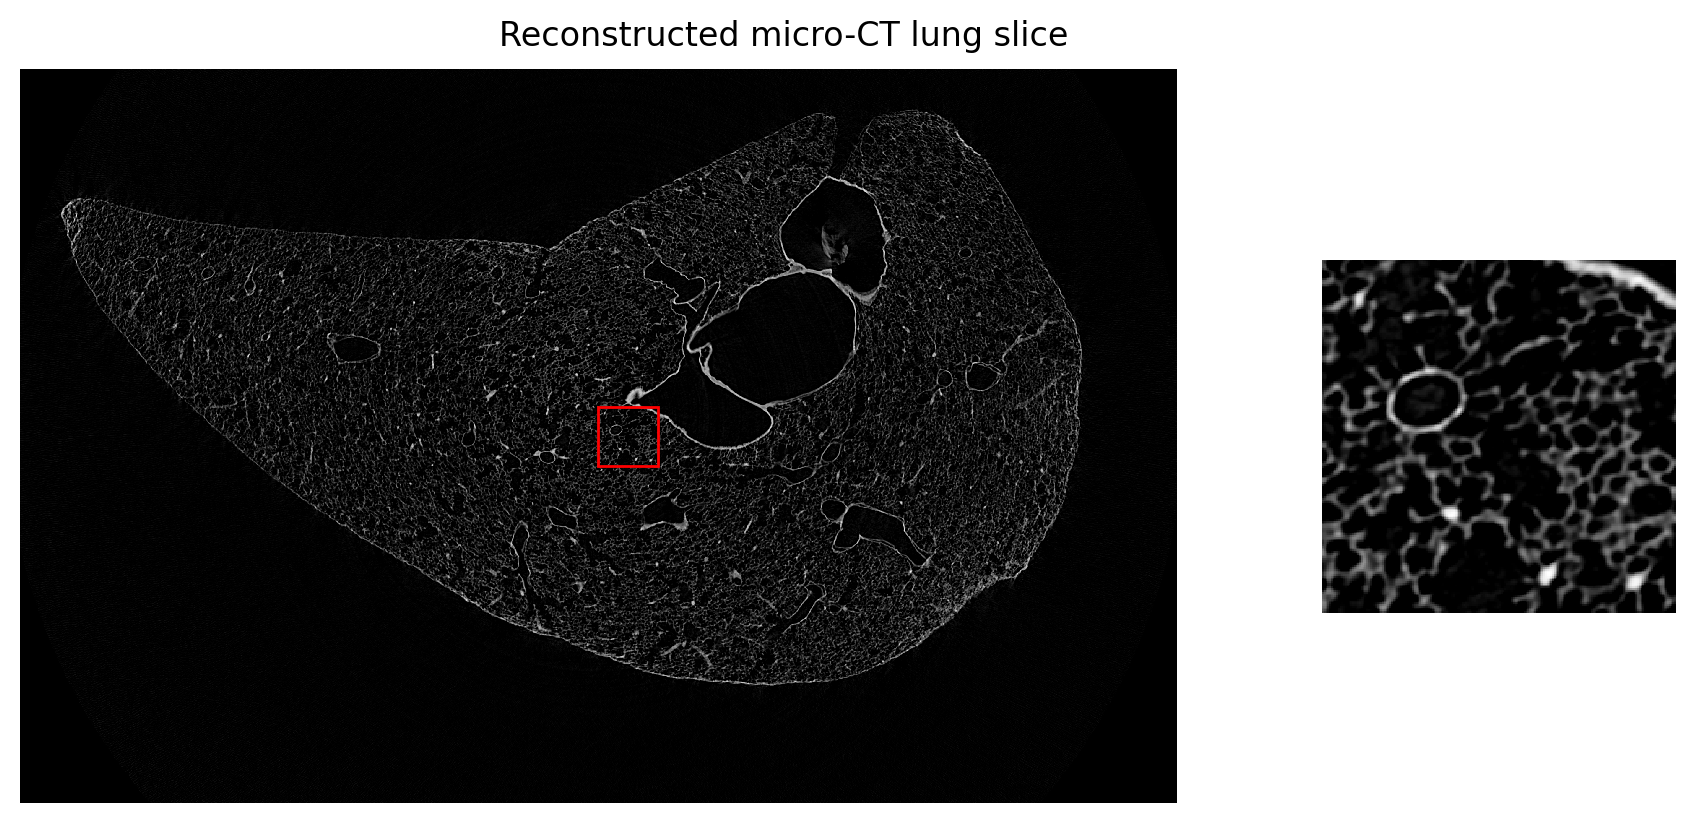

In [62]:
# Importing an already reconstructed slice
img = Image.open(r"1471_P2_M2.bmp")
# img = losa.load_image(r"1471_P2_M2.bmp")
slice = np.array(img)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), dpi=200, gridspec_kw={'width_ratios': [4, 1]}, layout='constrained')
ax1.imshow(slice, cmap=plt.cm.Greys_r, interpolation='nearest')
ax1.axis('off')

corner = [slice.shape[0]//2-100, slice.shape[1]//2]
vertex = [slice.shape[1]//2, slice.shape[0]//2-100]
side_length = 200

rect = patches.Rectangle(vertex, side_length, side_length, linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax2.imshow(extract_square(slice, corner, side_length), cmap=plt.cm.Greys_r, interpolation='nearest')
ax2.axis('off')
fig.suptitle("Reconstructed micro-CT lung slice")
plt.show()

In [63]:
# Zero-padding original image
print(np.max(slice))
print(np.min(slice))

height, width = slice.shape
print(f"before padding - height = {height}, width = {width}")

diff = width - height
pad_width = diff//2
slice = np.pad(slice, ((pad_width, pad_width), (0,0)), mode='constant', constant_values=0)
slice = np.roll(slice, 100, axis=(0,1))
nheight, nwidth = slice.shape
print(f"after padding  - height = {nheight}, width = {nwidth}")

226
0
before padding - height = 2484, width = 3916
after padding  - height = 3916, width = 3916


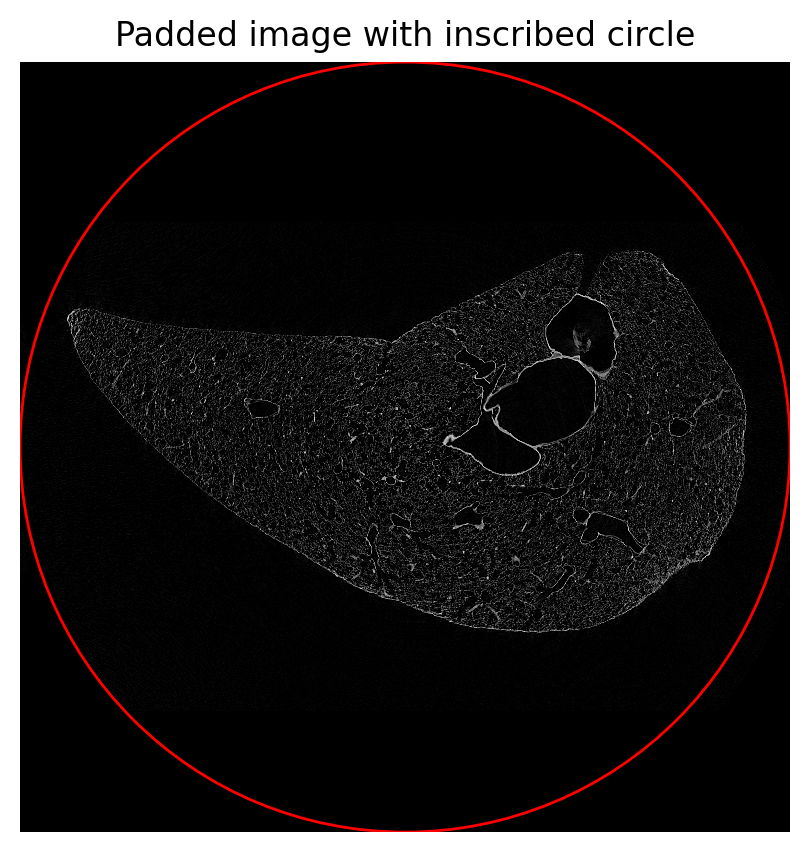

In [64]:
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.imshow(slice, cmap=plt.cm.Greys_r, interpolation='nearest')
circle = patches.Circle((nheight//2, nwidth//2), slice.shape[0]//2, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(circle)
ax.axis('off')
ax.set_title("Padded image with inscribed circle")
plt.show()

In [65]:
sino_slice = radon(slice, theta=np.arange(0.0, 180.0, step=0.2))

c:\Users\bherr\miniconda3\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


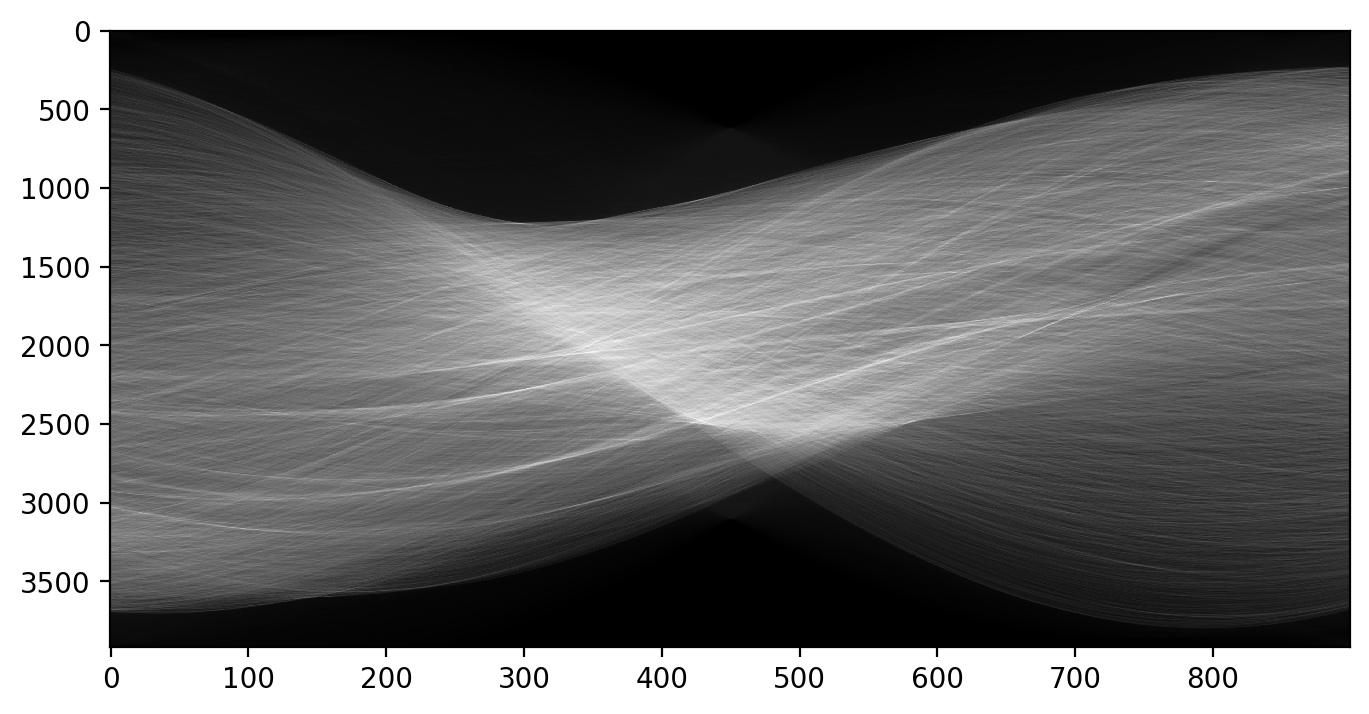

In [67]:
fig, ax = plt.subplots(figsize=(8,4), dpi=200)
ax.imshow(sino_slice, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
plt.show()

In [84]:
# height = 3916, width = 3916

detector_cols = nwidth

proj_geom = astra.create_proj_geom('parallel', 5.0, 3916, np.deg2rad(np.arange(0.0, 180.0, step=0.2)))
vol_geom = astra.create_vol_geom(detector_cols, 900)

projections_id = astra.data2d.create('-sino', proj_geom, sino_slice.T)
reconstruction_id = astra.data2d.create('-vol', vol_geom, data=0)


In [85]:
projector_id = astra.creators.create_projector("cuda", proj_geom, vol_geom) # voxel super sampling ?
proj_id, rec_slice_astra = astra.creators.create_sino(sino_slice.T, projector_id)

ValueError: The dimensions of the data do not match those specified in the geometry: (900, 3916) != (3916, 900)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8), dpi=200)
ax.imshow(rec_slice_astra, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
plt.show()

In [80]:
reconstructed_slice = iradon(sino_slice, theta=np.arange(0.0, 180.0, step=0.2), filter_name='ramp')

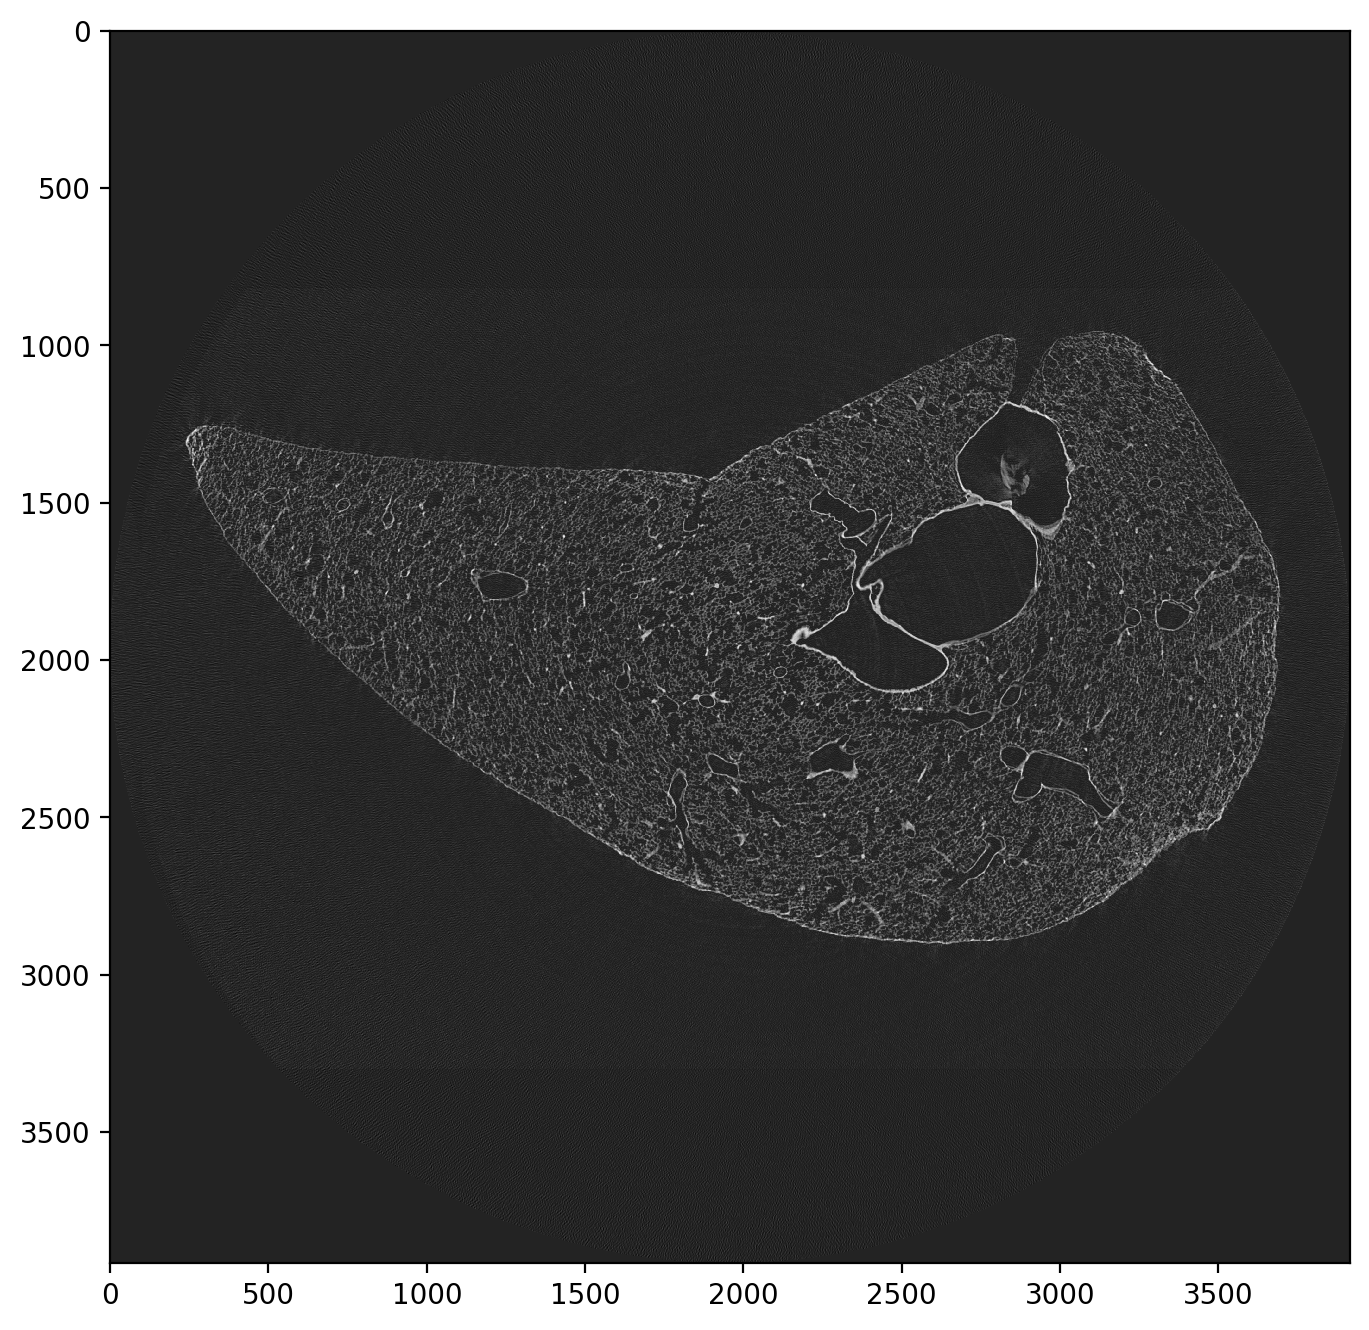

In [81]:
fig, ax = plt.subplots(figsize=(8,8), dpi=200)
ax.imshow(reconstructed_slice, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
algotom.prep.correction.upsample_sinogram